#**1.1.1 Data Understanding, Analysis, Visualization and Cleaning**

The dataset is for Multi-Class, Single image classification.
There are two different folders:

Train:
It contains the training images of various classes.
Test:
It contains the images, of which your model should predict.

The pictures are of various fruits and are divided into five classes: Banana; Cherry; Grape; Mango; Peach.
Each Class contains its corresponding fruit image.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import neccessary functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Number of images

In [ ]:
# key statistics about the dataset, such as the total number of images, number of classes,
# and the distribution of images per class.
import os
import pathlib

data_dir = pathlib.Path('/content/drive/MyDrive/Assesments/Fruit Classification')

image_count = 0
class_counts = {}

for class_name in os.listdir(data_dir / 'Train'):
    class_dir = data_dir / 'Train' / class_name
    if os.path.isdir(class_dir):  # Ensure it's a directory

        class_image_count = len(os.listdir(class_dir))
        image_count += class_image_count
        class_counts[class_name] = class_image_count

print(f"Total number of images: {image_count}")
print(f"Number of classes: {len(class_counts)}")
print("Distribution of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Total number of images: 6242
Number of classes: 5
Distribution of images per class:
Grape: 1468
Peach: 1222
Cherry: 1222
Banana: 1422
Mango: 908


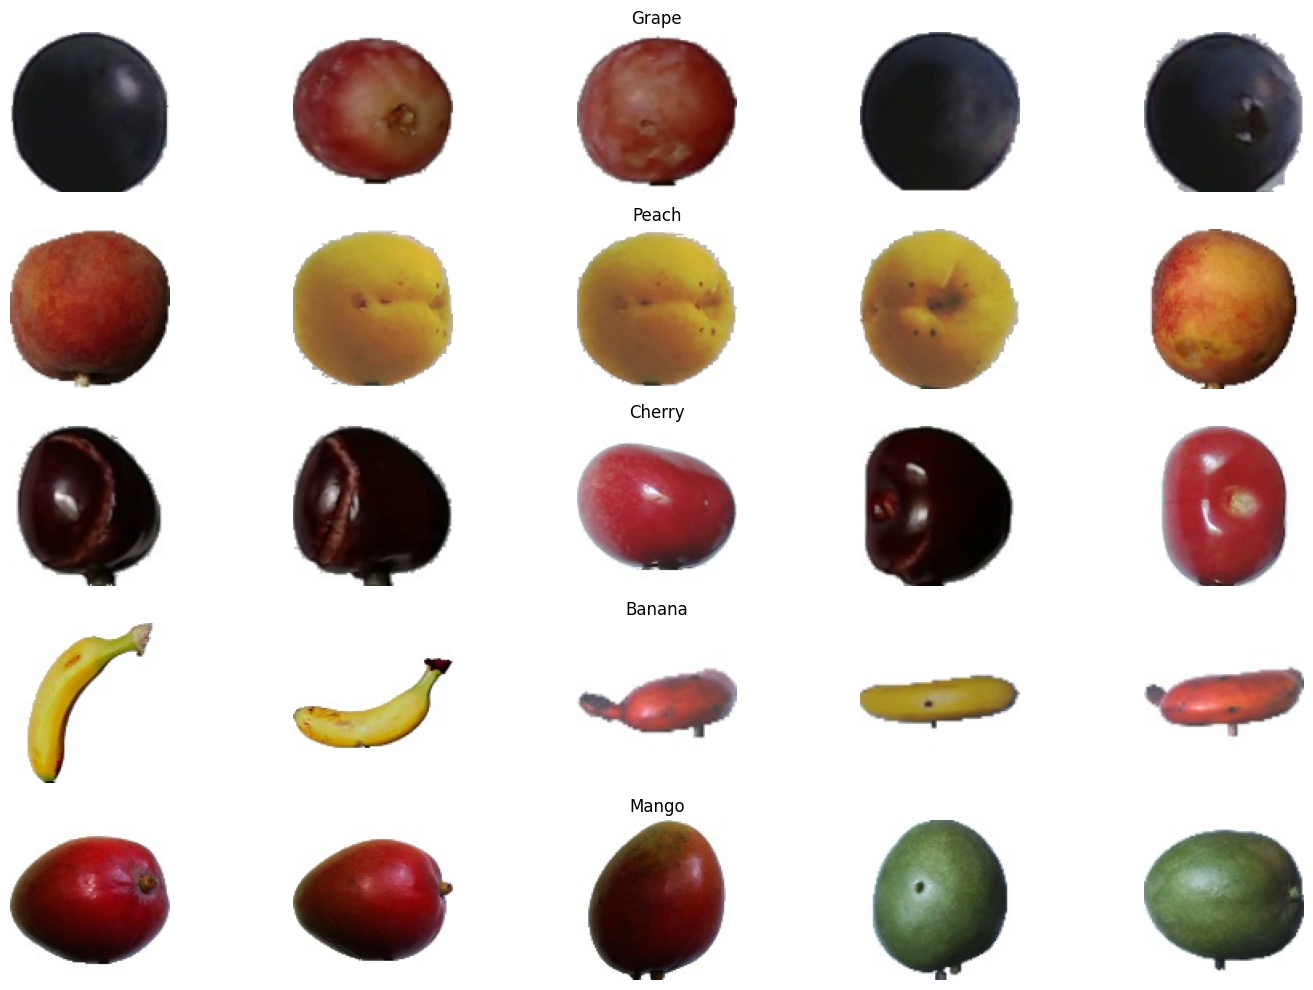

In [ ]:
# Basic visualizations to enhance the understanding of the dataset.
import matplotlib.pyplot as plt
import random

# Sample some images from each class for visualization
sample_images = {}
for class_name in class_counts:
    class_dir = data_dir / 'Train' / class_name
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    sample_images[class_name] = random.sample(image_files, min(5, len(image_files))) # Sample up to 5 images


# Display sample images
plt.figure(figsize=(15, 10))
for i, (class_name, images) in enumerate(sample_images.items()):
    for j, image_file in enumerate(images):
        plt.subplot(len(sample_images), 5, i*5+j+1)
        img = plt.imread(data_dir / 'Train' / class_name / image_file)
        plt.imshow(img)

        if j == 2: # Only show class label once per class
         plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()

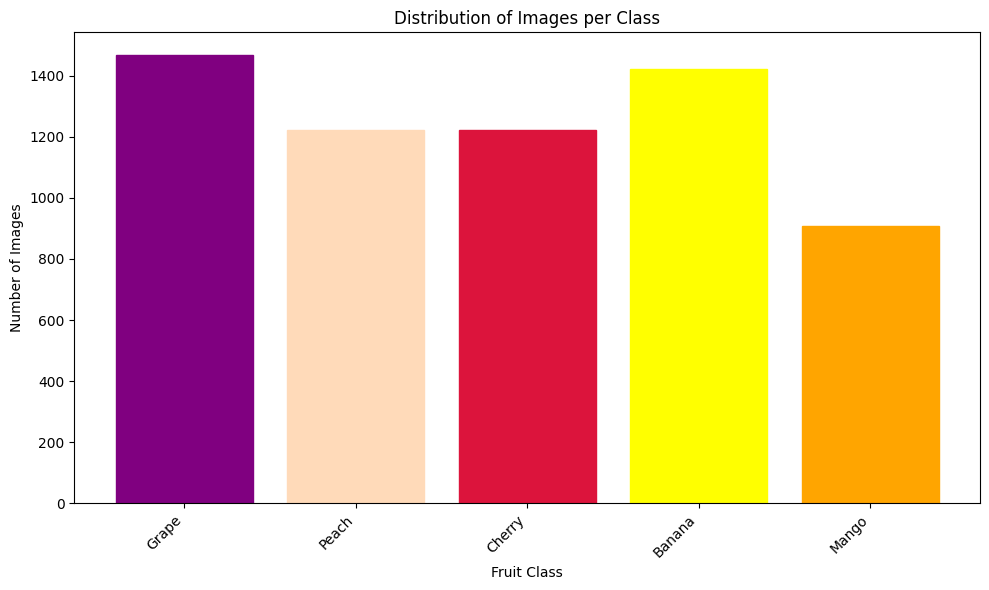

In [ ]:
# Define custom colors for each fruit class
colors = {
    'Banana': 'yellow',
    'Mango': 'orange',
    'Peach': 'peachpuff',
    'Grape': 'purple',
    'Cherry': 'crimson'
}

# Visualize class distribution with a bar graph and custom colors
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())

# Set custom colors for each bar
for bar, label in zip(bars, class_counts.keys()):
    bar.set_color(colors.get(label, 'lightgray'))  # Default to lightgray if color not defined

plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
import os

# verify each immage and throw exceptions
def verify_images_in_folder(folder_path):
    bad_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify the image is not corrupted
            except Exception as e:
                bad_files.append(file_path)
    return bad_files

# Set this to your train + test folder
train_folder = '/content/drive/MyDrive/Assesments/Fruit Classification/Train'
test_folder = '/content/drive/MyDrive/Assesments/Fruit Classification/Test'

bad_train = verify_images_in_folder(train_folder)
bad_test = verify_images_in_folder(test_folder)

print("Bad Train Images:", bad_train)
print("Bad Test Images:", bad_test)


Bad Train Images: []
Bad Test Images: ['/content/drive/MyDrive/Assesments/Fruit Classification/Test/untitled']


In [ ]:
for file_path in bad_train:
    if os.path.exists(file_path):
        print(f"Removing: {file_path}")
        os.remove(file_path)
    else:
        print(f"File not found, skipping: {file_path}")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use augmentation on training split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 split from train folder
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#initial call
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Assesments/Fruit Classification/Train',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

# Validation should NOT be augmented (only rescaled)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Path to your dataset's train folder
train_dir = '/content/drive/MyDrive/Assesments/Fruit Classification/Train'

# Training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
val_data = val_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 6242 images belonging to 5 classes.
Found 4996 images belonging to 5 classes.
Found 1246 images belonging to 5 classes.


#**1.1.2 Design, Train, and Evaluate a Baseline Mode**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential([
    # 1st Conv layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer (adjust num_classes based on your dataset)
    Dense(train_data.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,277 (6.65 MB)

 Trainable params: 1,742,277 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

#Model Summary
* Simple structure 3 convolutional and max pooling layers and the flatten and 4 dense layers
* No regulariztion
* Smaller model so faster training time
* Total paramters approximately 1.74 million

In [ ]:
history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.3782 - loss: 1.4510 - val_accuracy: 0.5987 - val_loss: 0.9157
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.6897 - loss: 0.7964 - val_accuracy: 0.7552 - val_loss: 0.6551
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - accuracy: 0.7797 - loss: 0.5524 - val_accuracy: 0.7681 - val_loss: 0.4445
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8521 - loss: 0.4228 - val_accuracy: 0.9904 - val_loss: 0.2633
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.8916 - loss: 0.3206 - val_accuracy: 0.8925 - val_loss: 0.2243
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.9227 - loss: 0.2472 - val_accuracy: 0.9815 - val_loss: 0.1407
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.9424 - loss: 0.1943 - val_accuracy: 0.8957 - val_loss: 0.2777
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.9514 - loss: 0

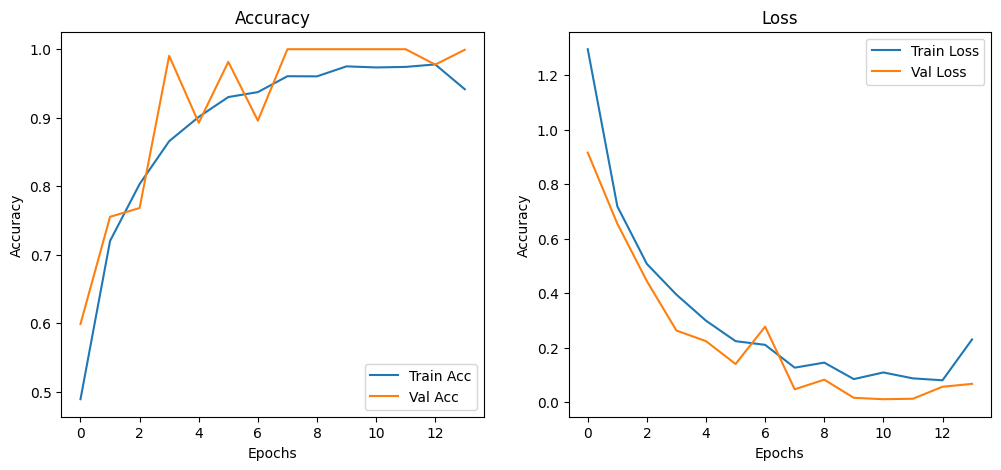

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Training & Validation Curves Accuracy
Both train and val accuracy increase steadily, hitting ~98-99%.

There's one fluctuation in val accuracy around epoch 6, but it recovers well.

No sign of overfitting — val accuracy follows train accuracy closely.

Loss
Train and val loss both decrease sharply and flatten towards zero.

Validation loss spikes at epoch 6, then continues dropping — may indicate brief instability or noisy batch.

Conclusion from Graphs: Very healthy learning curves. The model is learning effectively and generalizing well.

Precision, recall, F1 all excellent — especially for Cherry, Grape, and Peach.

Banana slightly misclassified 9 times as Mango (see confusion matrix).

Only notable error: 9 Bananas misclassified as Mango

Well-generalized, no overfitting.

Minor class confusion, probably data-related, not model-related.

In [ ]:
model.save("/content/drive/MyDrive/Assesments/Fruit Classification/fruit_classifier_model.keras")
class_indices = train_generator.class_indices #provide dictionary

import json
with open("label_map.json", "w") as f:
    json.dump(class_indices, f)  # class_indices comes from your ImageDataGenerator

In [ ]:
from tensorflow.keras.models import load_model

# Loading
model = load_model('/content/drive/MyDrive/Assesments/Fruit Classification/fruit_classifier_model.keras')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation set
val_preds = model.predict(val_data)
val_pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Classification report
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, val_pred_classes)
print("Confusion Matrix:\n", cm)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00       284
      Cherry       1.00      1.00      1.00       244
       Grape       1.00      1.00      1.00       293
       Mango       1.00      1.00      1.00       181
       Peach       1.00      1.00      1.00       244

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246

Confusion Matrix:
 [[284   0   0   0   0]
 [  0 244   0   0   0]
 [  0   0 293   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 244]]


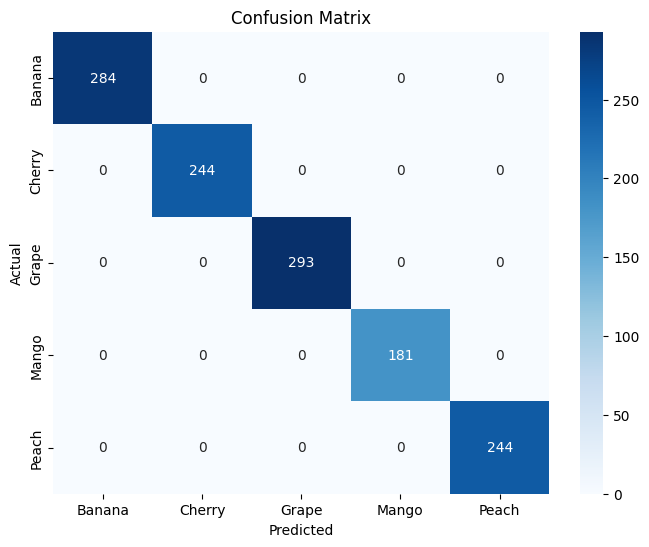

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# If you only have numeric labels, convert using the label map
y_true = true_classes
y_pred = val_pred_classes
class_indices = train_data.class_indices
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(class_indices.values()))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices.keys(),
            yticklabels=class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


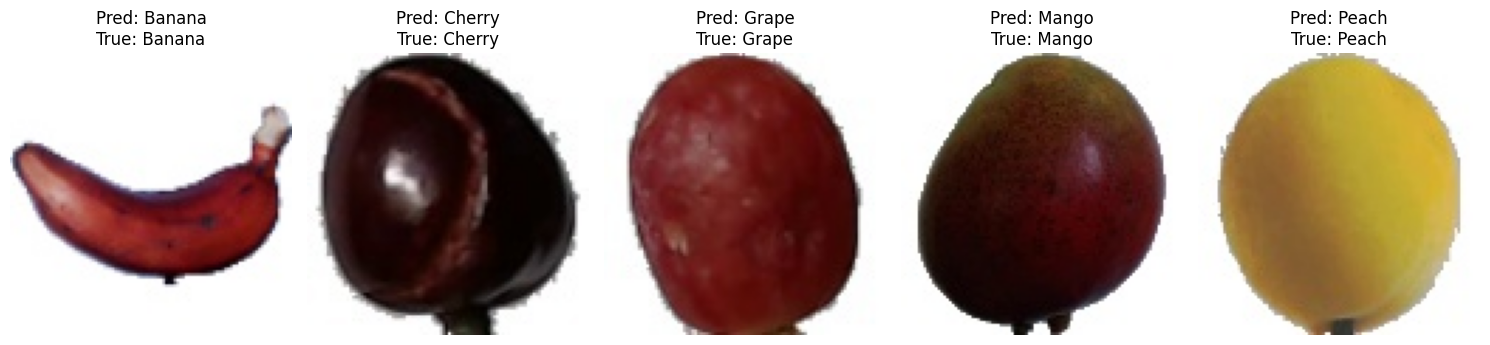

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get class names and indexes
class_indices = val_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
class_counts = {i: 0 for i in range(len(class_indices))}

sample_images = []
sample_labels = []

# Iterate over validation data until we collect one image per class
for images, labels in val_data:
    for img, label in zip(images, labels):
        class_id = np.argmax(label)
        if class_counts[class_id] == 0:  # If we haven't collected this class yet
            sample_images.append(img)
            sample_labels.append(class_id)
            class_counts[class_id] += 1

        # Stop if we've collected one image for each class
        if sum(class_counts.values()) == len(class_indices):
            break
    if sum(class_counts.values()) == len(class_indices):
        break

sample_images = np.array(sample_images)

# Predict using the deeper model
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot results
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {index_to_class[predicted_classes[i]]}\nTrue: {index_to_class[sample_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#**1.1.3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define deeper model
deep_model = Sequential([
    # 1st Conv layer
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # 2nd Conv layer
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3rd Conv layer
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer (adjust num_classes based on your dataset)
    Dense(5, activation='softmax')
])

# Compile the model
# deep_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary
deep_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976,805 (11.36 MB)

 Trainable params: 2,975,909 (11.35 MB)

 Non-trainable params: 896 (3.50 KB)

#Model Summary
* Deeper and wider network: more Conv2D layers, more filters.

* Batch normalization after each convolution stabilizes training and helps generalization.

* Dropout layers reduce overfitting.

* Higher total parameters (~3M), which increases learning capacity

In [ ]:
deep_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_deep = deep_model.fit(
    train_data,
    epochs=15,
    validation_data=val_data
)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 262ms/step - accuracy: 0.6974 - loss: 1.5875 - val_accuracy: 0.3957 - val_loss: 6.0403
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.8712 - loss: 0.6967 - val_accuracy: 0.2737 - val_loss: 15.2739
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - accuracy: 0.8646 - loss: 0.9082 - val_accuracy: 0.8917 - val_loss: 0.1987
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.9356 - loss: 0.2870 - val_accuracy: 0.9165 - val_loss: 0.4210
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.9524 - loss: 0.1753 - val_accuracy: 0.9992 - val_loss: 0.0197
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.9608 - loss: 0.1734 - val_accuracy: 0.9406 - val_loss: 0.1865
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.9530 - loss: 0.2399 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9563 - loss: 

total time 10 mins

In [ ]:
model.save("/content/drive/MyDrive/AIandMLfruit_classifier_model_deeper.keras")
class_indices = train_generator.class_indices

import json
with open("label_map.json", "w") as f:
    json.dump(class_indices, f)  # class_indices comes from your ImageDataGenerator

In [ ]:
from tensorflow.keras.models import load_model

# For folder format
model = load_model("/content/drive/MyDrive/Assesments/Fruit Classification/fruit_classifier_model.keras")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

val_preds_deep = deep_model.predict(val_data)
val_pred_classes_deep = np.argmax(val_preds_deep, axis=1)
true_classes = val_data.classes
print(classification_report(true_classes, val_pred_classes_deep, target_names=val_data.class_indices.keys()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00       284
      Cherry       1.00      1.00      1.00       244
       Grape       1.00      1.00      1.00       293
       Mango       1.00      1.00      1.00       181
       Peach       1.00      1.00      1.00       244

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246



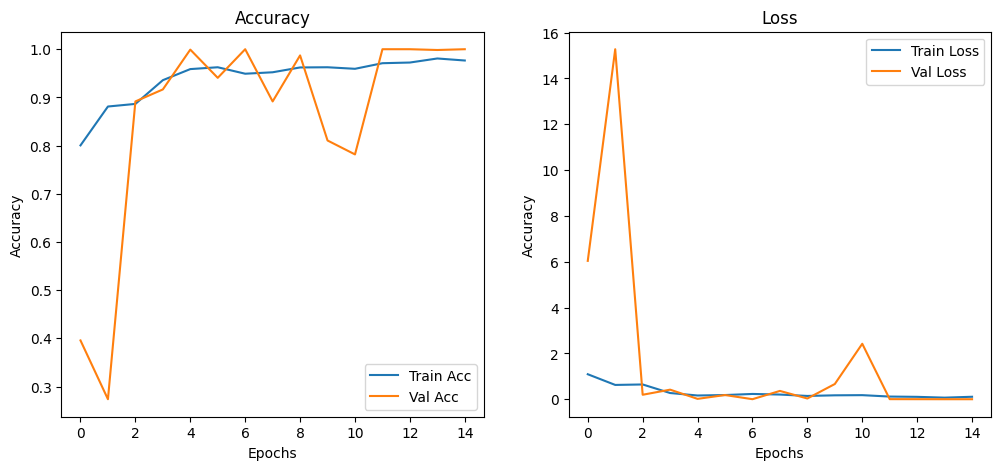

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'], label='Train Acc')
plt.plot(history_deep.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'], label='Train Loss')
plt.plot(history_deep.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#Comparing training time and loss curve against baseline model


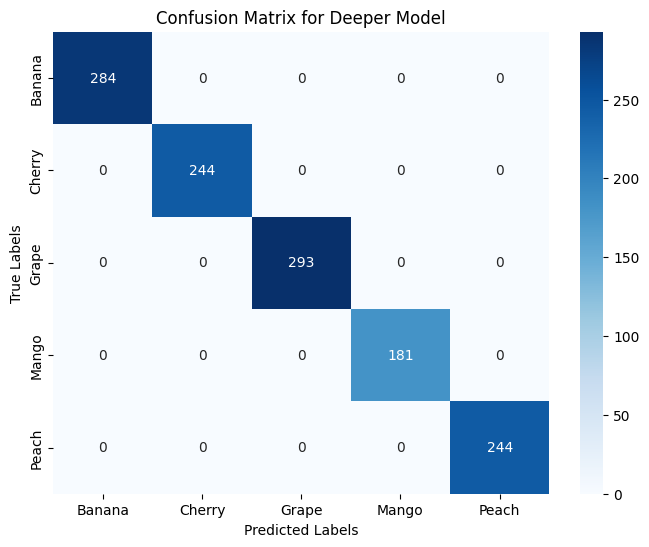

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(val_data.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_classes, val_pred_classes_deep)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Deeper Model')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


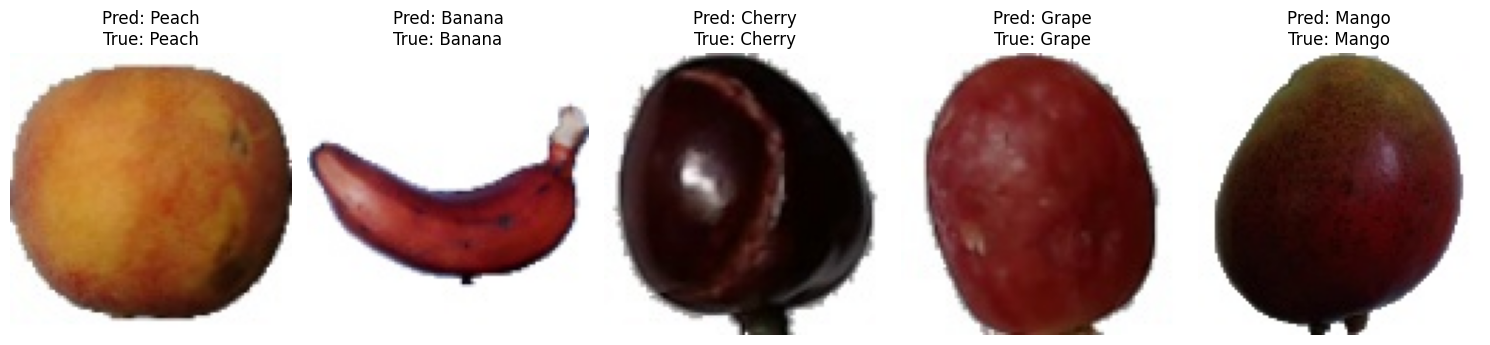

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names and indexes
class_indices = val_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
class_counts = {i: 0 for i in range(len(class_indices))}

sample_images = []
sample_labels = []

# Iterate over validation data until we collect one image per class
for images, labels in val_data:
    for img, label in zip(images, labels):
        class_id = np.argmax(label)
        if class_counts[class_id] == 0:
            sample_images.append(img)
            sample_labels.append(class_id)
            class_counts[class_id] += 1

        if sum(class_counts.values()) == len(class_indices):
            break
    if sum(class_counts.values()) == len(class_indices):
        break

sample_images = np.array(sample_images)

# Predict using the deep model
predictions = deep_model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot results
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {index_to_class[predicted_classes[i]]}\nTrue: {index_to_class[sample_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


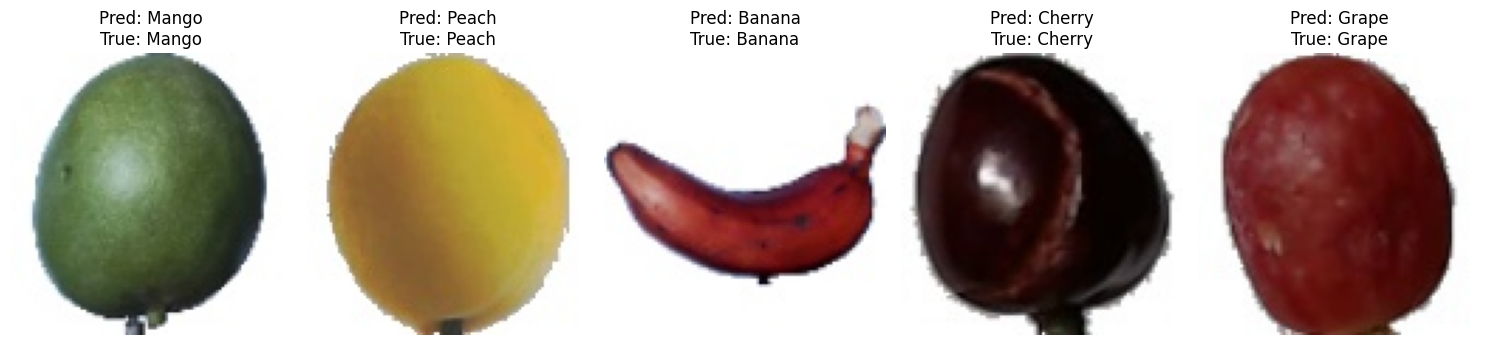

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get class names and indexes
class_indices = val_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
class_counts = {i: 0 for i in range(len(class_indices))}

sample_images = []
sample_labels = []

# Iterate over validation data until we collect one image per class
for images, labels in val_data:
    for img, label in zip(images, labels):
        class_id = np.argmax(label)
        if class_counts[class_id] == 0:  # If we haven't collected this class yet
            sample_images.append(img)
            sample_labels.append(class_id)
            class_counts[class_id] += 1

        # Stop if we've collected one image for each class
        if sum(class_counts.values()) == len(class_indices):
            break
    if sum(class_counts.values()) == len(class_indices):
        break

sample_images = np.array(sample_images)

# Predict using the deeper model
predictions = deep_model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot results
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {index_to_class[predicted_classes[i]]}\nTrue: {index_to_class[sample_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#**1.1.4 Experimentation and Comparative Analysis**

1. Baseline vs. Deeper Model Performance

  Baseline Model

The results clearly indicate that the deeper model did not improve performance, in fact, it performed significantly worse than the baseline model.  

2. Training time

baseline model 6 minutes
deeper model 9 minutes



In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
import time
from tensorflow.keras.models import clone_model
# Function to compile and train model
def train_with_optimizer(optimizer, optimizer_name):
    # Create a copy of the original model to avoid modifying it directly
    model = clone_model(deep_model)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\nTraining with {optimizer_name} optimizer:")
    start_time = time.time()

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=15,
        verbose=1
    )

    total_time = time.time() - start_time
    print(f"Total training time with {optimizer_name}: {total_time:.2f} seconds")

    # Evaluate the model
    loss, accuracy = model.evaluate(val_data)
    print(f"Validation Accuracy with {optimizer_name}: {accuracy:.4f}")
    print(f"Validation Loss with {optimizer_name}: {loss:.4f}")

    return history, accuracy, loss, total_time

# Train with SGD
sgd = SGD(learning_rate=0.01, momentum=0.9)
sgd_history, sgd_acc, sgd_loss, sgd_time = train_with_optimizer(sgd, "SGD")

# Train with Adam
adam = Adam(learning_rate=0.001)
adam_history, adam_acc, adam_loss, adam_time = train_with_optimizer(adam, "Adam")


Training with SGD optimizer:
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - accuracy: 0.6088 - loss: 1.7108 - val_accuracy: 0.7006 - val_loss: 2.4000
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.8081 - loss: 0.6517 - val_accuracy: 0.6838 - val_loss: 2.7807
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.8630 - loss: 0.4522 - val_accuracy: 0.9872 - val_loss: 0.1493
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.9101 - loss: 0.3154 - val_accuracy: 0.8283 - val_loss: 0.6772
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9052 - loss: 0.3524 - val_accuracy: 0.9799 - val_loss: 0.1109
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 207ms/step - accuracy: 0.9449 - loss: 0.2177 - val_accuracy: 0.9109 - val_loss: 0.3636
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.9477 - loss: 0.2293 - val_accuracy: 0.9711 - val_loss: 0.0916
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/ste

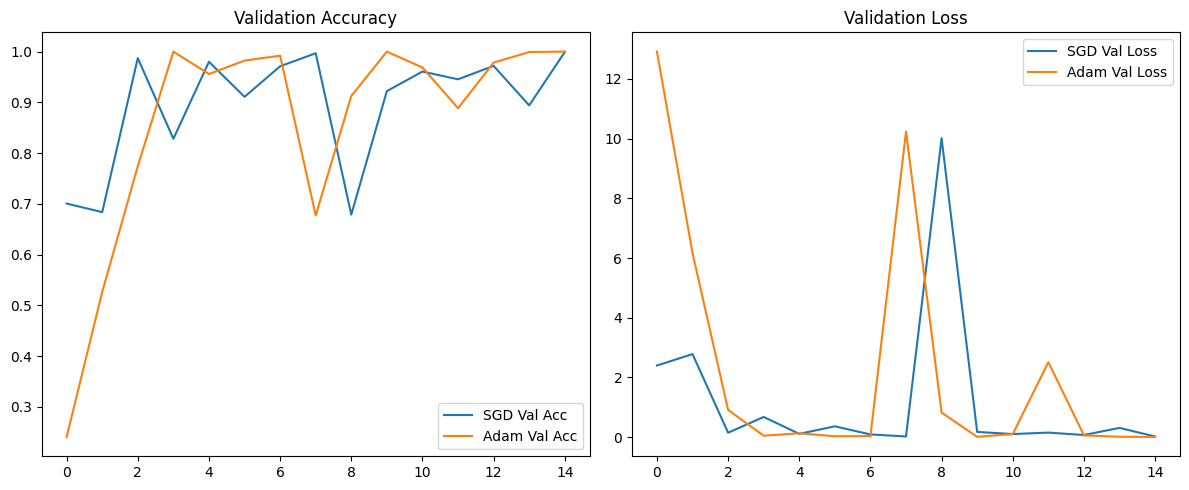

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history1, history2, label1='SGD', label2='Adam'):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=f'{label1} Val Acc')
    plt.plot(history2.history['val_accuracy'], label=f'{label2} Val Acc')
    plt.title('Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=f'{label1} Val Loss')
    plt.plot(history2.history['val_loss'], label=f'{label2} Val Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(sgd_history, adam_history)


trainngin total 18min


#**1.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)**

1st epoch always longer

1hr 1st time

2nd 10mins

runtime reset 3rd 40mins 1sty epoch rest go faster 46 mins total

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Parameters
IMAGE_SIZE = (224, 224)  # Required input size for VGG16
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Assesments/Fruit Classification/Train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Assesments/Fruit Classification/Train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load VGG16 base model without top classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base (feature extraction)
for layer in base_model.layers:
    layer.trainable = False

# Add new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Better than Flatten for transfer learning
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model (feature extraction phase)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Found 4996 images belonging to 5 classes.
Found 1246 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 312ms/step - accuracy: 0.2567 - loss: 1.6943 - val_accuracy: 0.5152 - val_loss: 1.3740
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.5003 - loss: 1.3404 - val_accuracy: 0.7512 - val_loss: 1.1911
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.6828 - loss: 1.0820 - val_accuracy: 0.8483 - val_loss: 1.0409
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.7666 - loss: 0.9177 - val_accuracy: 0.8531 - val_loss: 0.9127
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.8204 - loss: 0.7893 - val_accuracy: 0.8788 - val_loss: 0.8017
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.8507 - loss: 0.6937 - val_accuracy: 0.8748 - val_loss: 0.7141
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.8791 - loss: 0.6071 - val_accuracy: 0.8812 - val_loss: 0.6394
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.8925 - loss: 0

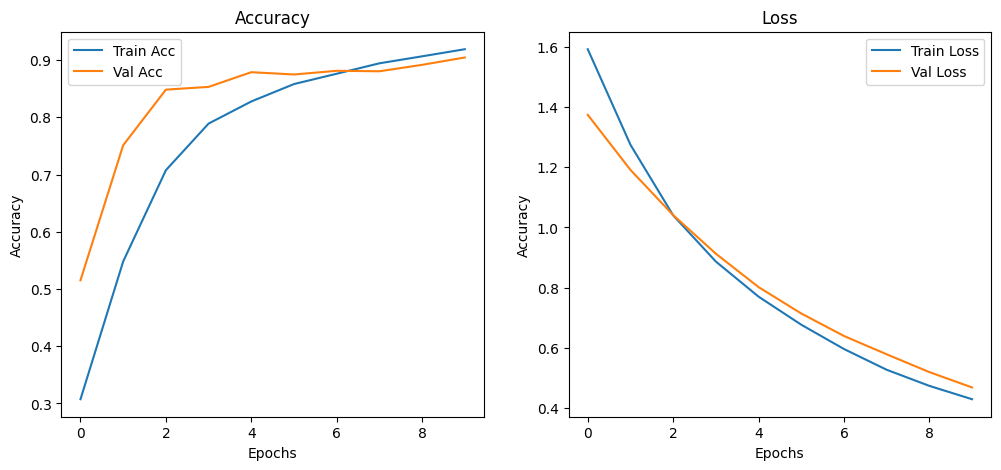

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

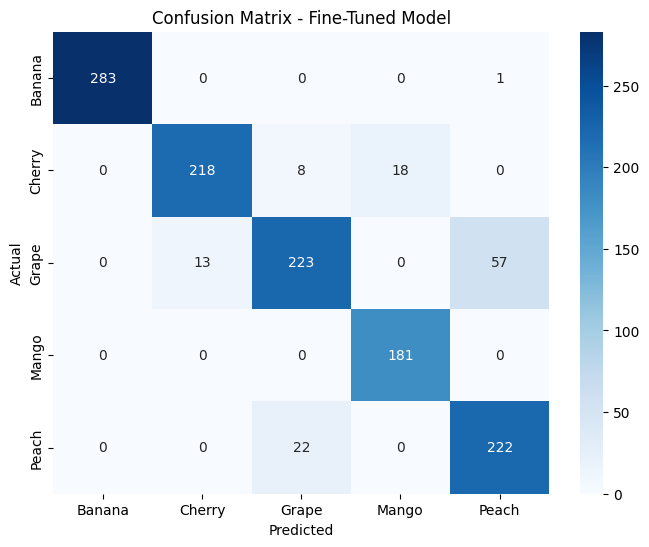

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
val_data.reset()  # Reset generator to avoid index errors
y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_data.samples:
        break

y_true = np.array(y_true[:val_data.samples])
y_pred = np.array(y_pred[:val_data.samples])

# Classification report
class_names = list(val_data.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fine-Tuned Model')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


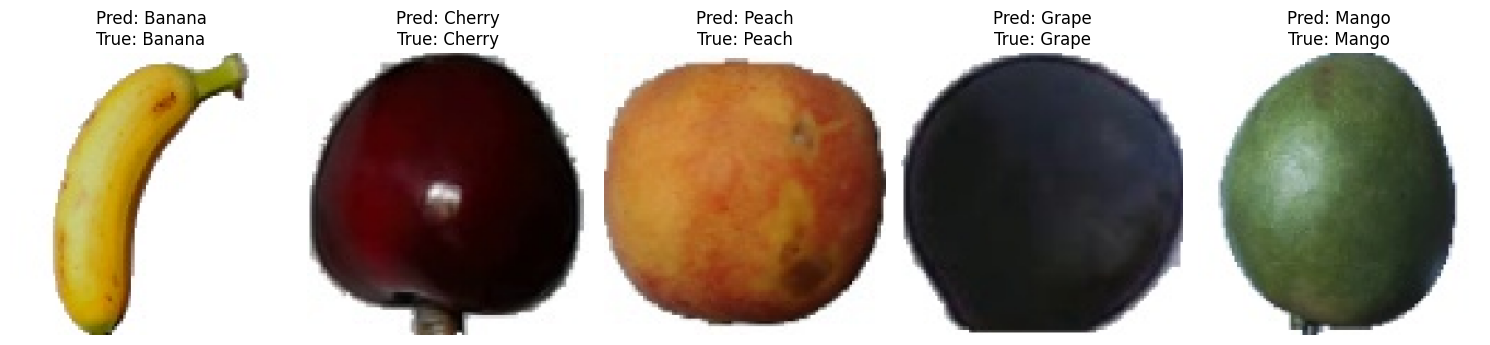

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get class names and indexes
class_indices = val_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
class_counts = {i: 0 for i in range(len(class_indices))}

sample_images = []
sample_labels = []

# Iterate over validation data until we collect one image per class
for images, labels in val_data:
    for img, label in zip(images, labels):
        class_id = np.argmax(label)
        if class_counts[class_id] == 0:  # If we haven't collected this class yet
            sample_images.append(img)
            sample_labels.append(class_id)
            class_counts[class_id] += 1

        # Stop if we've collected one image for each class
        if sum(class_counts.values()) == len(class_indices):
            break
    if sum(class_counts.values()) == len(class_indices):
        break

sample_images = np.array(sample_images)

# Predict using the deeper model
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot results
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {index_to_class[predicted_classes[i]]}\nTrue: {index_to_class[sample_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()